Assignment-5

Your main task for this assignment is to combine Linear Regression, Greedy Algorithm and PnL discussed in lecture to predict your trading results. You will be predicting Bitcoin price this time. You should refer to the ipynb file for this tutorial to get the structure. 

This time the prediction will be slightly different from the Lab. Every prediction should be a result from a model that is trained based on the previous 400 days. Example: if you are predicting 1-1-2019, the model should be trained using the previous 400 days, and so on.


The instruction to the assignment are as follow:

1. Read BTC price data
2. Only keep `close` column for analysis.
3. Create features that correspond to the time interval in which we want to predict
4. Drop all rows with missing value.
5. Set `fix_history_length` equal to 400, `fix_test_length` equal to 100
6. Use Greedy Algorithm instead of All Subset Selection
7. Find 50 different samples of Return using the given seed format
8. Use a histogram to summarize your result. Make sure to adjust the histogram settings to make it look nice

The total running time should be about 7 hours. Do not shut down your kernel during the computation.

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model
from sklearn.model_selection import train_test_split

In [2]:
BTC_price_origin = pd.read_csv('BTC-USD.csv',index_col = 'Date')
BTC_price_origin = BTC_price_origin[['Close']]

BTC = BTC_price_origin.copy()

# compute Return
BTC['Return'] = BTC.Close.diff()/BTC.Close

# change index into date format
BTC.index = pd.to_datetime(BTC.index, format='%Y-%m-%d')

In [3]:
BTC

,Close,Return
Date,,
2015-03-07,274.910004,NaN
2015-03-08,274.489990,-0.001530
2015-03-09,290.019989,0.053548
2015-03-10,291.369995,0.004633
2015-03-11,295.600006,0.014310
...,...,...
2019-03-03,3812.310059,-0.008034
2019-03-04,3731.280029,-0.021716
2019-03-05,3874.179932,0.036885


In [4]:
predictor_variables = ['1D','3D','1W','2W','3W','1M','6W','2M','3M','4M','5M','6M','9M','1Y']
def ShiftNum(var):
    if var[1]=='D':
        return int(var[0])
    elif var[1]=='W':
        return int(var[0])*7
    elif var[1]=='M':
        return int(var[0])*30
    elif var[1]=='Y':
        return int(var[0])*365
    else:
        return("Please give a str whose format is xD, xW, xM, xY.")

# shift Return by the value of each feature
for var in predictor_variables:
    name = 'Return_' + var
    BTC[name] = BTC.Return.shift(ShiftNum(var))

# drop the first 250 rows (cuz they do not have feature '1Y')
BTC = BTC.dropna()
target = ['Return']
features = BTC.columns.values.tolist()[2:]

In [5]:
fix_history_length = 400
fix_test_length = 100
sample_size = 50
randomRange = len(BTC) - fix_history_length - fix_test_length

In [6]:
# compute Long-short value
def computation(df):
    for i in range(1,len(df)):
        if df.iloc[i,1]>=0:
            df.iloc[i,2] = df.iloc[i-1,2] * (1 + df.iloc[i,0])
        else:
            df.iloc[i,2] = df.iloc[i-1,2] * (1 - df.iloc[i,0])
    return df

In [7]:
def PnL(data, target, proportion):

    train_sub, valid_sub = train_test_split(data, test_size = proportion, random_state = 0)

    # create a linear model
    X_train = train_sub.drop(target, axis = 1)
    Y_train = train_sub[target]
    X_valid = valid_sub.drop(target, axis = 1)
    Y_valid = valid_sub[target]
    
    model = linear_model.LinearRegression()
    model.fit(X_train, Y_train)
    Y_valid_fit = model.predict(X_valid)   

    # a data frame for computing and saving long_short value
    long_short_df = pd.DataFrame({'Return': Y_valid.iloc[:,0].values,
                                  'Predicted Return': Y_valid_fit.reshape(1,-1)[0].tolist(),
                                  'Long-short value': np.zeros(len(valid_sub))},
                                 index = valid_sub.index)
    
    cols = ['Return', 'Predicted Return', 'Long-short value']
    long_short_df = long_short_df[cols]
    
    # give an initial point
    initial = pd.DataFrame(np.array([0,0,1]).reshape(-1,3),
                       columns = long_short_df.columns)

    # combine df and initial point
    long_short_df = pd.concat([initial, long_short_df])

    # compute long_short value
    long_short_df_final = computation(long_short_df)

    # return final long_short value of this period
    return long_short_df_final.iloc[-1,2]

In [8]:
def greedy_algo(train_valid, target, proportion):
    
    # initialize a list to save features
    greedy_select = []
    
    profit_greedy_algo = np.array([])
    for i in range(len(features)):
        profit = np.array([])
        features_left = list(set(features) - set(greedy_select))

        for new in features_left:
            features_new = greedy_select + [new]
            train_valid_sub = train_valid[features_new + target]

            # CrossValidation, compute the profit and save it into profit_sub
            profit_sub = PnL(train_valid_sub, target, proportion)
            profit = np.append(profit, profit_sub)

        # pick the features that gives the largest profit
        # and add it into our features list
        # meanwhile, save the corresponding profit
        greedy_select += [features_left[profit.argmax()]]
        profit_greedy_algo = np.append(profit_greedy_algo, profit.max())
        
    return greedy_select[:profit_greedy_algo.argmax()+1]

In [ ]:
%%time
profit_final = np.array([])

# Think about why we need two loops here:
# The answer is that this time, we need to change the training data for each day, each sample
# In total, we have 50 samples
for j in range(sample_size): #change 1 into sample size
    np.random.seed(j)
    random_Num = np.random.randint(randomRange)
    
    Y_test_fit = np.array([])
    for i in range(fix_test_length):  

        BeginTime = random_Num + i
        timestamp = fix_history_length + BeginTime
        EndTime = BeginTime + fix_test_length + fix_test_length

        train_valid = BTC.iloc[BeginTime:timestamp, : ]
        
        feature_update = greedy_algo(train_valid, target, 0.2)
        
        X_cv = train_valid[feature_update]
        Y_cv = train_valid[target]

        model_cv = linear_model.LinearRegression()
        model_cv.fit(X_cv, Y_cv)
        
        test = BTC.iloc[timestamp : timestamp + 1,:]
        X_test = test[feature_update]
        Y_test = test[target]
        
        model = linear_model.LinearRegression()
        model.fit(X_cv, Y_cv)
        Y_test_fit = np.append(Y_test_fit,model.predict(X_test))
        
    Y_test_list = BTC.iloc[random_Num + fix_history_length : random_Num + fix_history_length + fix_test_length, 1]
    long_short_df = pd.DataFrame({'Return': Y_test_list,
                                  'Predicted Return': Y_test_fit,
                                  'Long-short value': np.zeros(fix_test_length)},
                                 index = Y_test_list.index)
    
    cols = ['Return', 'Predicted Return', 'Long-short value']
    long_short_df = long_short_df[cols]
    
    # give an initial point
    initial = pd.DataFrame(np.array([0,0,1]).reshape(-1,3),columns = long_short_df.columns)
    # combine df and initial point
    long_short_df = pd.concat([initial, long_short_df])
    # compute long_short value
    long_short_df_final = computation(long_short_df)
   
    profit_final = np.append(profit_final,long_short_df_final.iloc[-1,2])
        

In [36]:
# restored from last run
profit_final = np.asarray([1.68888102, 0.89403204, 0.98898046, 0.31366224, 1.19808599,
       0.35156756, 0.38741442, 1.00649273, 0.5552195 , 0.56689965,
       0.37959508, 0.85557617, 0.56747156, 0.71038407, 0.68147143,
       0.54995524, 0.28436433, 0.26557388, 0.53820138, 0.7435868 ,
       0.75770602, 0.3364802 , 1.39244591, 1.07941005, 0.68550108,
       1.39244591, 0.60873911, 1.05425014, 0.38302342, 0.72103286,
       0.66370744, 0.96027153, 1.6273793 , 1.05803783, 0.70399837,
       0.33166927, 0.8744897 , 0.79293656, 0.70399837, 0.59046151,
       0.53148523, 0.85557617, 1.71473566, 0.60782915, 0.67566062,
       0.68002279, 0.79870475, 1.48961758, 0.94669361, 0.74627344])

In [37]:
profit_final.min()

0.26557388

In [38]:
profit_final.max()

1.71473566

Text(1.2, 5, '100 test points')

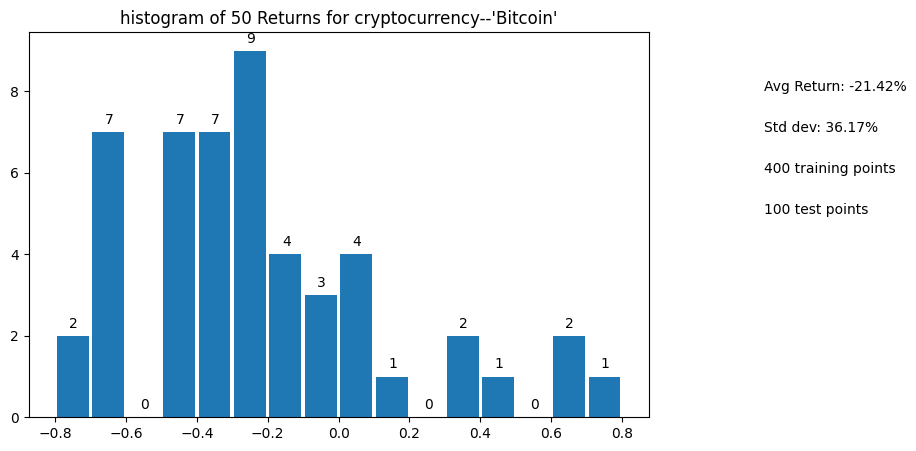

In [41]:
fig = plt.figure(figsize=(8,5))
bins = np.linspace(0.2-1, 1.8-1, 17)
a = plt.hist(profit_final-1, bins, histtype='bar', rwidth=0.9)
for i in range(len(bins)-1):
    plt.text(a[1][i]+0.04,a[0][i]+0.2,int(a[0][i]))
plt.title("histogram of 50 Returns for cryptocurrency--'Bitcoin'")

# you should change the coordinates of the plot to make it look nice
pos_x = 1.2
pos_y = 8
plt.text(pos_x, pos_y, ("Avg Return: {0:.2f}%".format((profit_final.mean() - 1) * 100)))
plt.text(pos_x, pos_y - 1, ("Std dev: {0:.2f}%".format(profit_final.std() * 100)))
plt.text(pos_x, pos_y - 2, "400 training points")
plt.text(pos_x, pos_y - 3, "100 test points")